In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

summ = pd.read_csv('summtab.csv')

cross['Part'] = 1
cross2 = Table.read('part2files.csv')
cross2 = join(cross2,full,keys='src_n')
cross2['Part'] = 2

In [2]:
mlist1 = ['OII I','OIII I']
mlist2 = ['OII I','OIII I','OIV I']

In [60]:
def cut(srcn,cut=10,npoints=False,time=False,retstd=True,retrange=False,calib=False,plot=True,text=False,statistic='median',glob=False,retsplit=False,window=200): #decide whether to do fixed chunks or fixed factor chunks or fixed number of points
    '''Divide LC into chunks and find median in each
    Division can be by number of points per piece or by total number of pieces.
    cut: number of pieces or number of points per piece or number of days per piece, depending on bool npoints and bool time
    npoints: if True, cut determines (approx) number of points per chunk; if False, cut determines total number of pieces
    time: if True, cut gives number of days included in each chunk
    retstd: return standard deviation of median values
    retrange: return range of median values
    calib: calibrate data by setting the medians of OII,OIII, and OIV to the same
    plot: plot LC
    retsplit: if True, return right after splitting; returns the split days,I mags, and det I lists
    TO DO: CHOOSE BETWEEN ORIGINAL AND DETRENDED
    '''
    #make sure plt.text not used if not plotting
    if not plot: text = False
    if srcn in cross['src_n']:
        c = cross
        mlist = mlist1
    else:
        c = cross2
        mlist = mlist2
    if glob: 
        global iband
        iband = o.getIV(srcn,c,calib=calib,both=False,stack=True,plot=plot,mlist=mlist,printall=False)
    else: iband = o.getIV(srcn,c,calib=calib,both=False,stack=True,plot=plot,mlist=mlist,printall=False)
    #detrend with spline
    flatten,trend = o.splinedetrend(iband,retspline=True,window=window)
    if npoints: cut = int(len(iband)/cut)+1
    #time cut means #days per piece, so divide total time by that to get number of pieces
    if time: cut = int((iband['MJD-50000'][-1:]-iband['MJD-50000'][:1])/cut)
    imagsplit = np.array_split(iband['I mag'],cut)
    splinesplit = np.array_split(iband['I detrend'],cut)
    #retsplit means just split up the values and return rather than calculating stat
    if retsplit:
        timesplit = np.array_split(iband['MJD-50000'],cut)
        trendsplit = np.array_split(trend,cut)
        return timesplit,imagsplit,splinesplit,trendsplit
    stats = []
    #TO DO: option to calculate statistic on detrended instead
    for i in range(cut):
        if statistic=='median': stat = np.median(imagsplit[i])
        elif statistic=='mean': stat = np.mean(imagsplit[i])
        elif statistic=='max': stat = np.max(imagsplit[i])
        elif statistic=='min': stat = np.min(imagsplit[i])
        elif statistic=='IQR': stat = scipy.stats.iqr(imagsplit[i])
        elif statistic=='stdev': stat = np.std(imagsplit[i])
        elif statistic=='skew': stat = scipy.stats.skew(imagsplit[i])
        elif statistic=='kurtosis':stat = scipy.stats.kurtosis(imagsplit[i])
        else: print('please enter valid statistic');return
        stats.append(stat)
    #add standard deviation of medians to plot
    if text:
        plt.text(np.median(iband['MJD-50000'])-1000,np.min(iband['I mag'])+.04,f'stdev of {statistic}s of {cut} chunks: {np.std(stats):.2f}')
    if retstd and retrange: return np.std(meds), np.max(meds)-np.min(stats)
    elif retstd: return np.std(stats)
    elif retrange: return p.max(stats)-np.min(stats)
    else: return stats

In [10]:
#functions from Stack Overflow for checking for monotonicity
def strictly_increasing(L):
    return all(x<y for x, y in zip(L, L[1:]))

def strictly_decreasing(L):
    return all(x>y for x, y in zip(L, L[1:]))

def non_increasing(L):
    return all(x>=y for x, y in zip(L, L[1:]))

def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))

def monotonic(L):
    return non_increasing(L) or non_decreasing(L)

In [12]:
sta = [1,3,4,11,2]
np.mean(sta)+np.std(sta)

7.744009029333871

In [14]:
sta = np.array(sta)
sta[sta>np.mean(sta)+np.std(sta)]

array([11])

In [47]:
def outlier(srcn,ncut=10,npoints=False,time=False,calib=False,plot=True,text=False,statistic='median',glob=False,retsplit=False,window=200,printall=True,sig=1):
    '''use cut function to get stats, and then differentiate between outliers and repeated changes
    also check for monotonic changes
    sig: stdev from mean to be considered outlier'''
    #get list of stats for srcn
    stats = cut(srcn,cut=ncut,npoints=npoints,time=time,retstd=False,retrange=False,calib=calib,plot=plot,text=plot,statistic=statistic,glob=glob,retsplit=retsplit,window=window)
    if printall:
        if strictly_increasing(stats): print(f'{statistic} is strictly increasing')
        elif strictly_decreasing(stats): print(f'{statistic} is strictly decreasing')
    #look for outliers in stats (in this case: one sigma from mean)
    stats = np.array(stats)
    upfilt = stats>np.mean(stats)+sig*np.std(stats)
    lowfilt = stats<np.mean(stats)-sig*np.std(stats)
    upouts = stats[upfilt]
    lowouts = stats[lowfilt]
    #get # of chunk with those outliers
    uploc = list(np.where(upfilt)[0]+1) #add one for indexing to start at 1 (first chunk)
    lowloc = list(np.where(lowfilt)[0]+1)
    if printall: 
        print(f'{len(upouts)} values of {statistic} {sig} sigma from mean using {ncut} LC chunks')
        print(f'above outliers at chunks {uploc} out of {ncut}')

        print(f'{len(lowouts)} upper outliers of {statistic} {sig} sigma from mean using {ncut} LC chunks')
        print(f'above outliers at chunks {lowloc} out of {ncut}')
    return stats

2 values of stdev 1 sigma from mean using 10 LC chunks
above outliers at chunks [9, 10] out of 10
0 upper outliers of stdev 1 sigma from mean using 10 LC chunks
above outliers at chunks [] out of 10


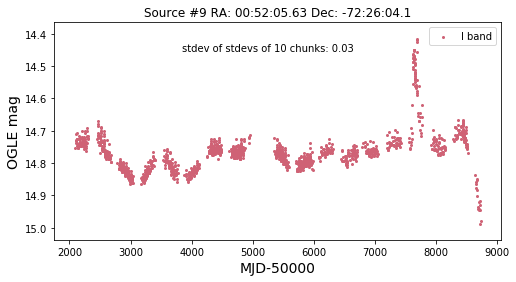

In [61]:
#in print statement, identifies that there are two outliers, which are at the end
#to do: use this info to show that aperiodic, at least within this window
stats = outlier(9,ncut=10,sig=1,statistic='stdev')

[14.759, 14.828, 14.764, 14.7895, 14.772, 14.721]

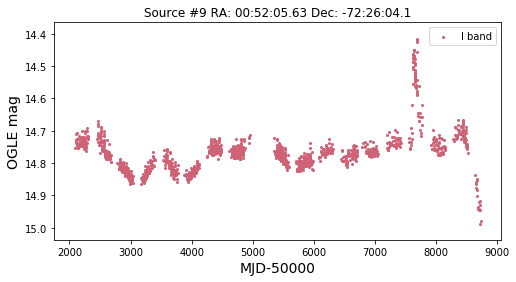

In [4]:
cut(9,cut=1000,retstd=False,glob=True,time=True)

# test cut() as indicator of long-term variability
- do I agree by-eye?
- particularly should identify very long-term trends/big dips rather than periodic high variability

- change in min (peak) is pretty good, and could be divided by overall standard deviation to be independent of range

0.14571533893176827
divided by stdev:  0.483418684029013
0.09986270575144601
divided by stdev:  0.8054970260901241
0.26194732294871803
divided by stdev:  1.5534154138910412
0.053471487729443365
divided by stdev:  0.14371209551337336
0.29771019465245113
divided by stdev:  1.1215807703653655
0.23156942803401323
divided by stdev:  0.9473163948010519
0.04568851059073803
divided by stdev:  0.6946674330658333
0.05315787806148797
divided by stdev:  0.8995179144911379
0.12769588873569887
divided by stdev:  0.9104752485519576


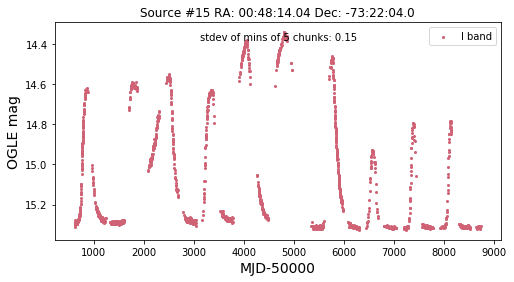

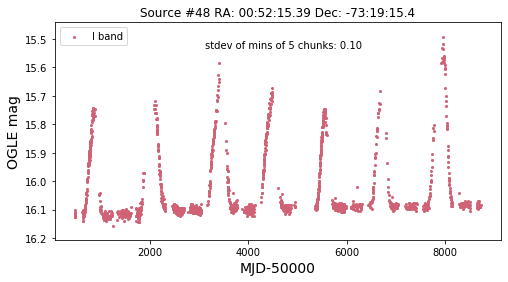

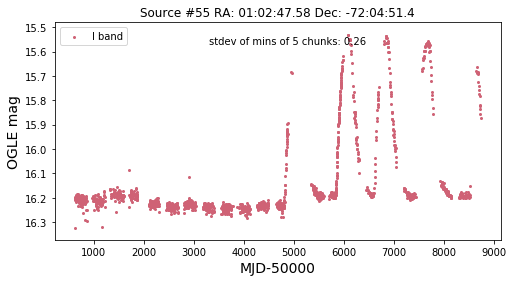

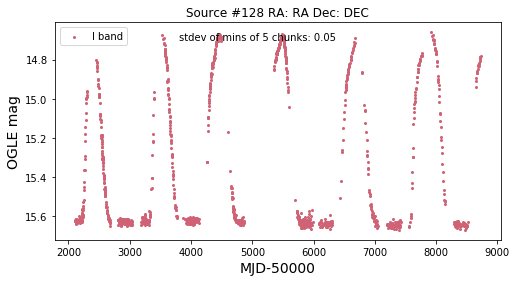

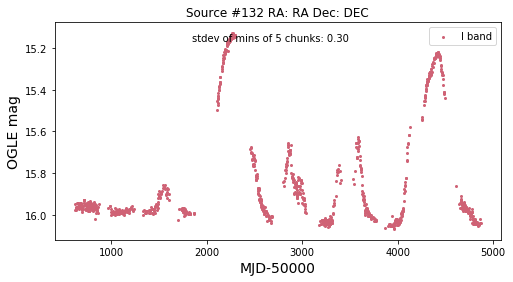

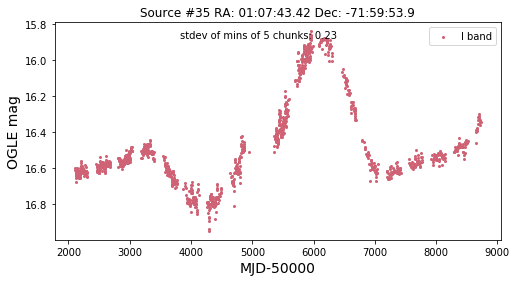

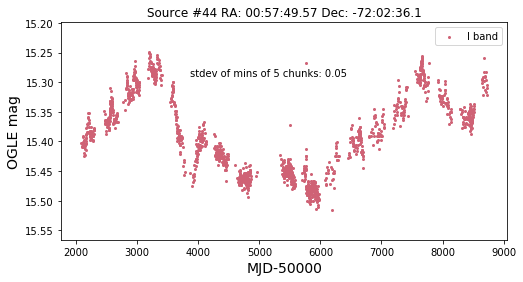

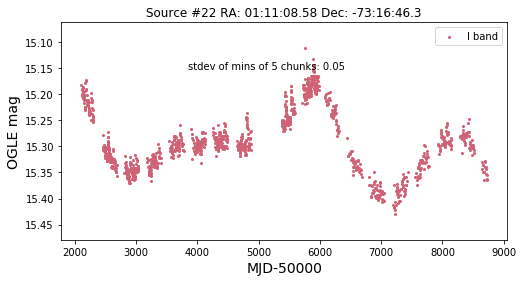

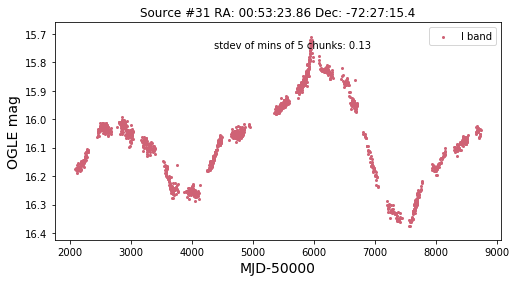

In [5]:
for s in [15,48,55,128,132,35,44,22,31]:
    stat = cut(s,cut=5,retstd=True,text=True,glob=True,statistic='min')
    print(stat)
    print('divided by stdev: ',stat/np.std(iband['I mag']))

In [8]:
#kurtosis for example (and probs others) single out the one with a dramatic change
# for s in [15,48,55,128,132,35,44,22,31]:
#     stat = cut(s,cut=5,retstd=True,text=True,glob=True,statistic='kurtosis')
#     print(stat)
##     print('divided by stdev: ',stat/np.std(iband['I mag']))

option to look for outliers vs. repeated changes
- max and min stdevs could be used equivalently for finding a base
    - would have to find cutoffs, but could be more "rigorous" than other method

0.028265880492211775
0.06056599706105739
0.12738225936134143
0.2933425301588576


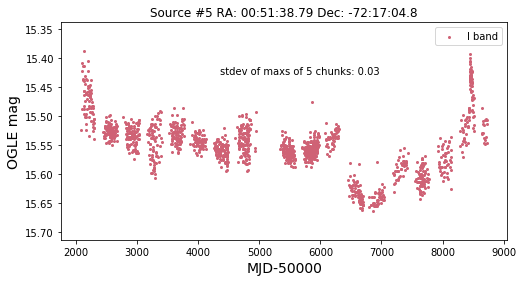

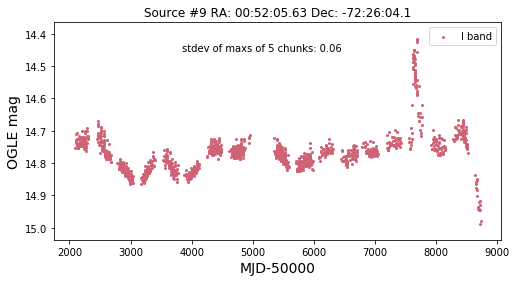

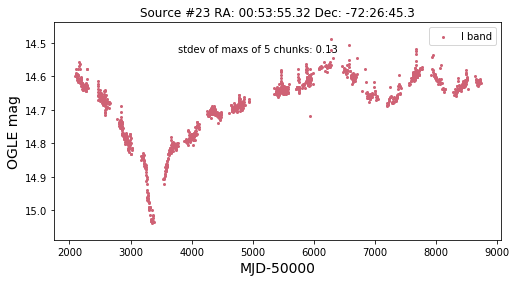

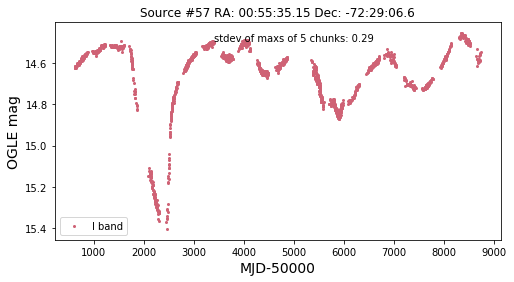

In [9]:
for s in [5,9,23,57]:
    stat = cut(s,cut=5,retstd=True,text=True,glob=True,plot=True,statistic='max')
    print(stat)

In [6]:
#same sources but max (faintest point) -- these combined could be good way to confirm base
#faint base sources have lower change in max than the last four, which don't have a base
for s in [15,48,55,128,132,35,44,22,31]:
    stat = cut(s,cut=5,retstd=True,text=True,glob=True,plot=False,statistic='max')
    print(stat)

0.006675327707311864
0.016906803364325776
0.043471369888698576
0.010707007051458833
0.01899894733926138
0.1910430318017384
0.044048155466488936
0.03548520818594682
0.09917782010106878


# Look for Changes in Phase-Folded Data in Chunks of LC
- use periods that are established from X-ray or otherwise confident for now
    - future: good way of disproving period
- use properties dictionaries and see how they change
    - correlations with magnitude or nearby color properties?
- have option to plot on one plot or double check by separate plots
    - need to update phase step to help with a global ylim (or can normalize?)
- **first have cut function return detrended I mag as well**

In [4]:
def detvar(src,num=10,plot=True):
    '''Use chunks to find changes in detrended variability
    Give mean I mag, stdev of detrended data, and mean time for each chunk
    Two plots: stdev vs. mean and stdev overlain on I band LC'''
    times,mags,det,trend = cut(src,cut=num,glob=True,plot=False,retsplit=True)
    means = [] #mean I mag in segment
    stds = [] #stdev I mag in detrended segment
    mtimes = []
    for i in range(len(times)):
        means.append(np.mean(mags[i]))
        stds.append(np.std(det[i]))
        mtimes.append(np.mean(times[i]))
    fig,ax = plt.subplots(1,2,figsize=(12,4))
    im = ax[1].scatter(means,stds,c=mtimes)
    fig.colorbar(im,label='MJD-50000')
    ax[1].set_xlabel('Mean I band')
    ax[1].set_ylabel('Stdev Detrended I')
    ax[0].scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=4)
    #flip y axis
    maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
    ax[0].set_ylim(maxi+.05,mini-.05)
    ax1 = ax[0].twinx()
    ax1.scatter(mtimes,stds,color='black')
    ax[0].tick_params(axis='y', labelcolor=pink)
    plt.subplots_adjust(wspace=.3)
    return mtimes,means,stds

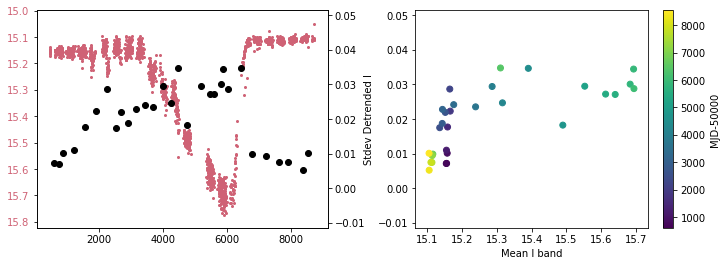

In [5]:
test = detvar(41,num=30)

In [18]:
def orbchunks(src,bp,num=5,pbins=16,det=True,findpd=False,plotlc=False,times=[],mags=[],detr=[],trend=[],save=False,file='',getstd=False):
    '''Make table of phase-folded properties after dividing LC into chunks'''
    #if chunks not passed in, use cut function
    if len(times)<1: times,mags,detr,trend = cut(src,cut=num,glob=True,plot=False,retsplit=True)
    fig = plt.figure(figsize=(22,4*int(num/5)))
    c = 1
    if findpd:
        #get period from summ table
        row = summ[summ['src_n']==src]
        #if there's a manually-filled best period, use that
        if float(row['best period'])>0: bp = float(row['best period'])
        #otherwise use best period from auto analysis
        else:bp = float(row['best auto det pd'])
    means = [] #calculate means of segments without detrending to get brightness
    if getstd: 
        #array to save all phase bin info
        avg_arr = np.zeros((num,pbins*2))
    for i in range(len(times)):
        ax = fig.add_subplot(1*int(num/5),5,c)
        #make segment into astropy table
        ib = Table({'MJD-50000':times[i],'I mag':mags[i],'I detrend':detr[i]})
        #construct dictionary (could be made more efficient since step calculated twice)
        pdict = o.combine(src,cross,full,iband=ib,det=det,pd=bp,pbins=pbins,close=True,testbins=False)
        #get values for step function
        mid,avg,err = o.meanphase(ib,bp,pbins=pbins,det=det,double=True,sterr=True,stdev=True,divide=True)
        #save phase bin averages to array
        if getstd: avg_arr[i,:] = avg
        ax.step(mid,avg,where='mid',color='black',label=f'{bp:.2f}d')
        if c==1: ax.legend()
        plt.errorbar(mid,avg,yerr=err,color='grey',alpha=0.5)
        maxi,mini = np.nanmax(avg)+np.nanmax(err),np.nanmin(avg)-np.nanmax(err)
        ax.set_ylim(maxi,mini)
        #calculate mean I mag and add to list
        meanmag = np.mean(mags[i])
        means.append(meanmag)
        #turn first dictionary into main table
        if c==1:
            main = pd.DataFrame(pdict,index=[0])
            if det: ax.set_ylabel('Detrended I mag')
            else: ax.set_ylabel('I mag')
            ax.set_xlabel('Phase')
        #otherwise make table and stack it with main
        else: 
            temp = pd.DataFrame(pdict,index=[c-1])
            #add new row to table by concatenation
            main = pd.concat([main,temp])
        c+=1
    #take standard deviation for each phase bin
    if getstd: pstds = np.std(avg_arr,axis=0)
    if save: plt.savefig(file+'.png',dpi=150,bbox_inches='tight')
    #add I mag means to table
    main['mean I'] = means
    #plot LC with different colors for different segments
    if plotlc:
        plt.figure(figsize=(8,4))
        maxi,mini = 0,np.inf
        for i in range(len(times)):
            plt.scatter(times[i],mags[i],s=4)
            if np.max(mags[i])>maxi:maxi = np.max(mags[i])
            if np.min(mags[i])<mini:mini = np.min(mags[i])
            #plot trend
            plt.plot(times[i],trend[i],color='grey')
        plt.ylim(maxi+.04,mini-.04)
        plt.ylabel('I mag',fontsize=13)
        plt.xlabel('MJD-50000',fontsize=13)
    if getstd: return main,pstds
    else: return main

,period,amp,phase diff,phase max,phase min,shape,diff mean,mean,skew,kurtosis,symm sum,mean err,mean I
0,102.97,0.023610,0.4375,0.40625,0.96875,FRED,0.010997,16.950299,-0.340286,-1.197274,0.002271,0.003310,16.809130
1,102.97,0.027078,0.6250,0.65625,0.03125,FRED,0.015135,16.952393,0.052830,-0.559076,0.003360,0.003597,16.927344
2,102.97,0.031173,0.6250,0.53125,0.90625,not FRED,0.016797,16.951524,-0.020387,-1.393267,0.009080,0.004100,17.050838
3,102.97,0.030611,0.2500,0.53125,0.28125,not FRED,0.015982,16.951770,-0.045047,-0.941824,0.008393,0.003786,17.061179
4,102.97,0.038868,0.5625,0.46875,0.90625,not FRED,0.015505,16.949853,-0.631274,-0.770604,0.009266,0.004297,16.919721


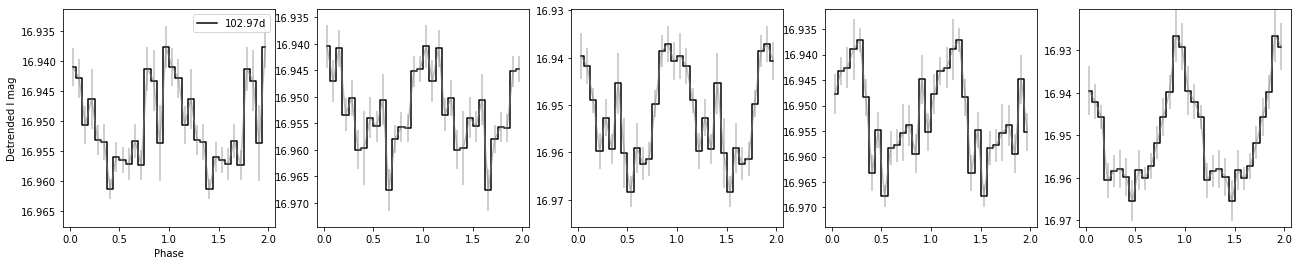

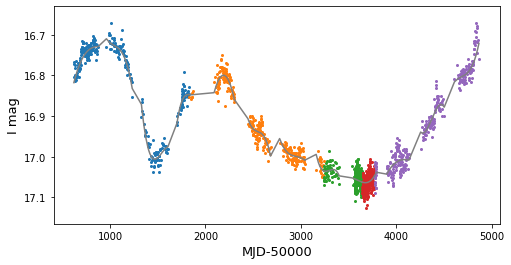

In [50]:
main = orbchunks(67,102.97,plotlc=True)
main

## Sources to Analyze for Now: Strong Period Signals 
- do big dip sources often have strong period signals?
- 96,115,141,19,2,22,64,4,9,10,16,17,23,25,26,28,30,34,36,40,45,48,50,62,63
- first check for best period; otherwise use best det
- 34 may not be good but curious to see
- later: good way to monitor changing phase of optical max


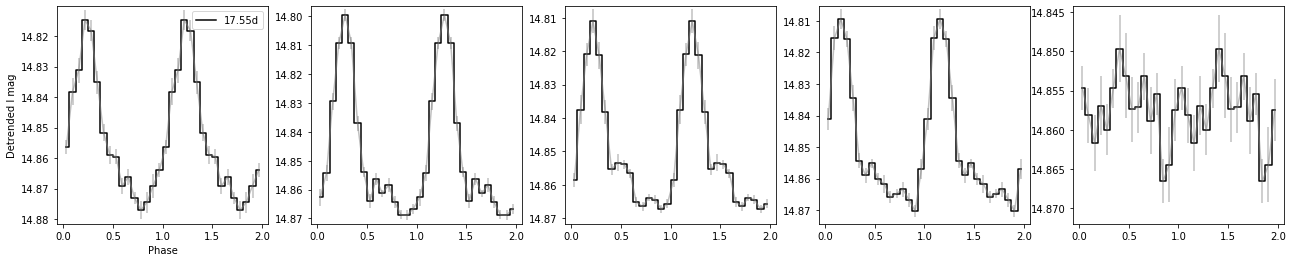

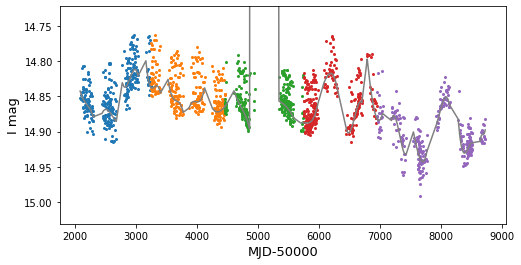

In [44]:
orbchunks(96,0,findpd=True,plotlc=True,save=True,file='Figs/period_disappearance96') #plotted LC b/c curious about what was happening at the end
plt.savefig('96chunks.png',dpi=150,bbox_inches='tight')

,period,amp,phase diff,phase max,phase min,shape,diff mean,mean,skew,kurtosis,symm sum,mean err,mean I
0,17.5496,0.068854,0.5000,0.78125,0.28125,not FRED,0.027196,14.852165,-0.661903,-0.612068,0.004393,0.004483,14.859630
1,17.5496,0.065339,0.6250,0.84375,0.21875,FRED,0.021135,14.854900,-0.823803,-0.647165,0.009759,0.003536,14.825098
2,17.5496,0.070617,0.5625,0.84375,0.28125,FRED,0.024225,14.847098,-0.906703,-0.641368,0.009253,0.002988,14.833163
3,17.5496,0.076472,0.6250,0.90625,0.28125,FRED,0.025467,14.848865,-1.064686,-0.249729,0.011206,0.002691,14.852379
4,17.5496,0.058746,0.7500,0.96875,0.21875,FRED,0.017050,14.849059,-1.119051,-0.099260,0.017890,0.003067,14.858654
5,17.5496,0.056275,0.5625,0.71875,0.15625,FRED,0.019210,14.850508,-0.881190,-0.656855,0.019569,0.002272,14.857425
6,17.5496,0.063079,0.5625,0.71875,0.15625,FRED,0.020302,14.847689,-0.922730,-0.631872,0.008312,0.002645,14.869484
7,17.5496,0.058070,0.7500,0.90625,0.15625,FRED,0.022928,14.851802,-0.833381,-0.607102,0.016688,0.003458,14.846484
8,17.5496,0.032169,0.6250,0.84375,0.21875,FRED,0.020520,14.858310,0.816789,-0.228856,0.000380,0.005605,14.911824
9,17.5496,0.033538,0.7500,0.21875,0.46875,not FRED,0.013242,14.857795,-0.844742,0.167189,0.005834,0.002766,14.899438


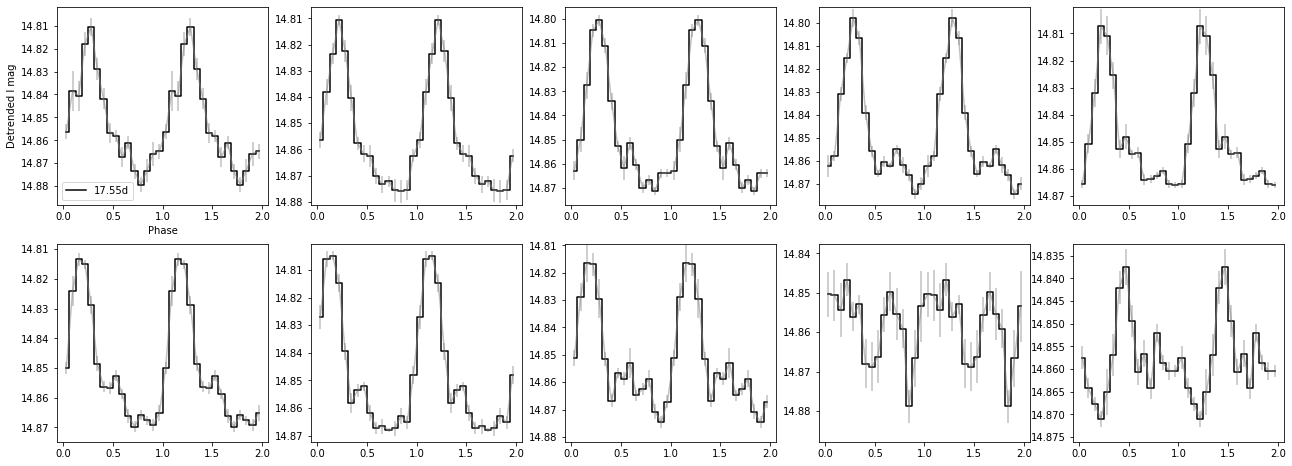

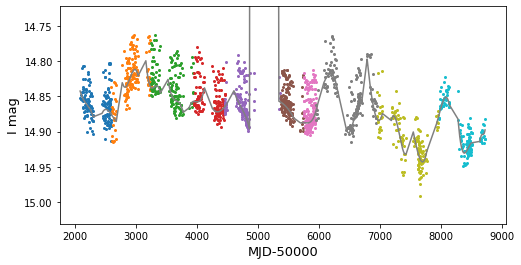

In [8]:
#try with 10 chunks instead of 5
orbchunks(96,0,num=10,findpd=True,plotlc=True)

In [9]:
#can separately investigate final chunk
iband = o.getIV(96,cross2,stack=True,both=False,mlist=mlist2)

In [10]:
#split into five chunks
tsplit = np.array_split(iband['MJD-50000'],5)
isplit = np.array_split(iband['I mag'],5)

In [11]:
#detrend whole iband
o.splinedetrend(iband,window=100)

#detrend just final chunk (final 306 points)
last = iband[-306:]
o.splinedetrend(last,window=100)

In [12]:
detsplit = np.array_split(iband['I detrend'],5)

(15, 14.8)

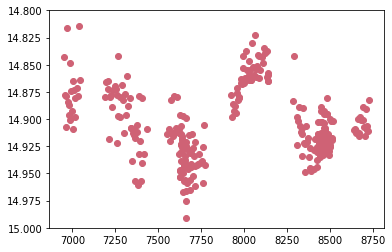

In [13]:
plt.scatter(tsplit[-1],isplit[-1],color=pink)
plt.ylim(15,14.8)

(14.95, 14.78)

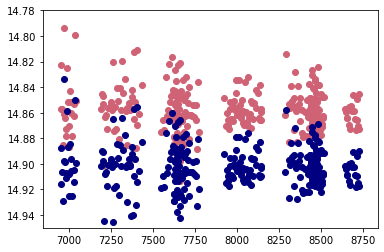

In [14]:
#only a vertical change when chunk detrended separately
plt.scatter(tsplit[-1],detsplit[-1],color=pink)
plt.scatter(tsplit[-1],last['I detrend'],color='navy')

plt.ylim(14.95,14.78)

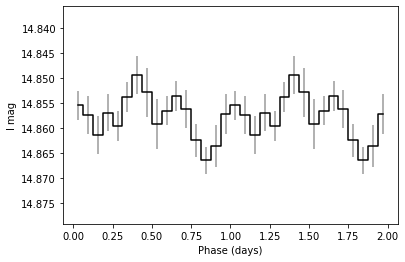

In [15]:
#fold using each detrend and original data
o.phasestep(iband[-306:],17.55,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=0,sterr=True,divide=True,label='')

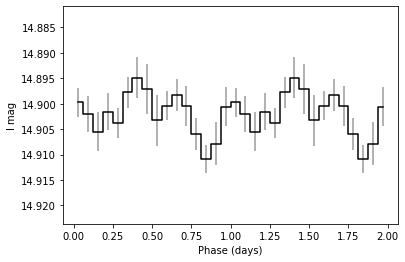

In [16]:
o.phasestep(last,17.55,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=0,sterr=True,divide=True,label='')

In [23]:
len(iband)

1531

(14.9, 14.78)

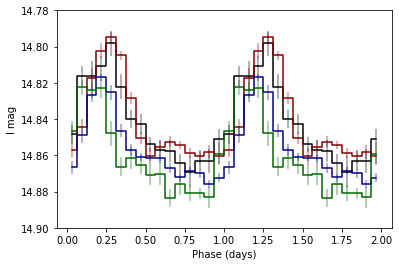

In [27]:
#for comparison: without detrending in other chunks
o.phasestep(iband[:300],17.55,16,det=False,med=False,double=True,color='black',err=True,retall=False,epoch=0,sterr=True,divide=True,label='')
o.phasestep(iband[300:600],17.55,16,det=False,med=False,double=True,color='maroon',err=True,retall=False,epoch=0,sterr=True,divide=True,label='')
o.phasestep(iband[600:900],17.55,16,det=False,med=False,double=True,color='navy',err=True,retall=False,epoch=0,sterr=True,divide=True,label='')
o.phasestep(iband[900:1200],17.55,16,det=False,med=False,double=True,color='darkgreen',err=True,retall=False,epoch=0,sterr=True,divide=True,label='')
plt.ylim(14.9,14.78)

(14.9, 14.78)

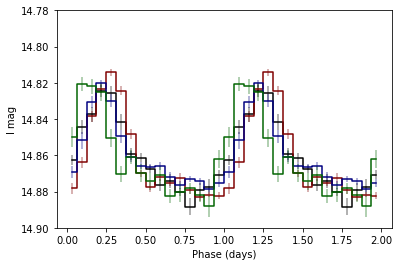

In [30]:
o.phasestep(iband[:300],17.55,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=0,sterr=True,divide=True,label='')
o.phasestep(iband[300:600],17.55,16,det=True,med=False,double=True,color='maroon',err=True,retall=False,epoch=0,sterr=True,divide=True,label='')
o.phasestep(iband[600:900],17.55,16,det=True,med=False,double=True,color='navy',err=True,retall=False,epoch=0,sterr=True,divide=True,label='')
o.phasestep(iband[900:1200],17.55,16,det=True,med=False,double=True,color='darkgreen',err=True,retall=False,epoch=0,sterr=True,divide=True,label='')
plt.ylim(14.9,14.78)

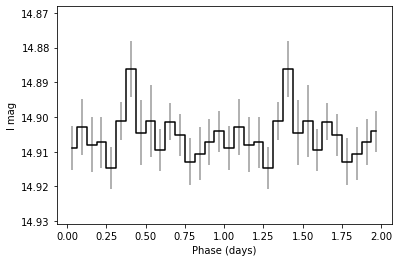

In [19]:
#original data; no detrending
o.phasestep(iband[-306:],17.55,16,det=False,med=False,double=True,color='black',err=True,retall=False,epoch=0,sterr=True,divide=True,label='')

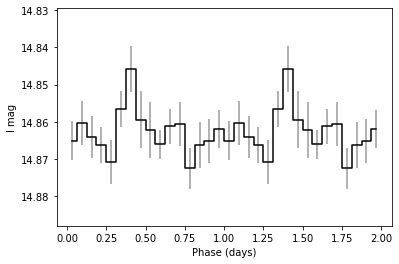

In [29]:
#replace detrending with S-G detrending
o.detrend(iband,window=101)
o.phasestep(iband[-306:],17.55,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=0,sterr=True,divide=True,label='')

<Quantity 17.5266797>

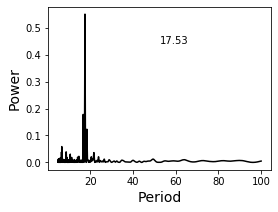

In [41]:
o.periodogram(iband[:300],minp=5,maxp=100,det=True) #similar with and without detrending

<Quantity 17.38597188>

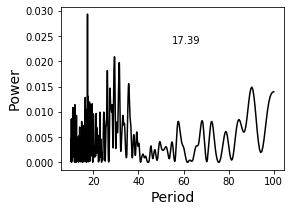

In [39]:
#periodogram in last part: look at difference in power from above
#if minp5, max at 5.77
o.periodogram(iband[-306:],minp=10,maxp=100,det=True) #similar with or without detrending

nearly identical results even with changed spline detrend arguments
- hard to tell significance esp. with 300 points over ~2000 days but really does seem to change

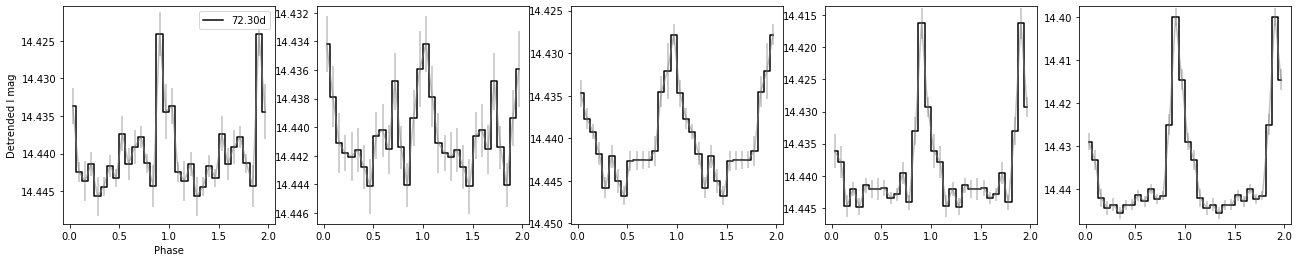

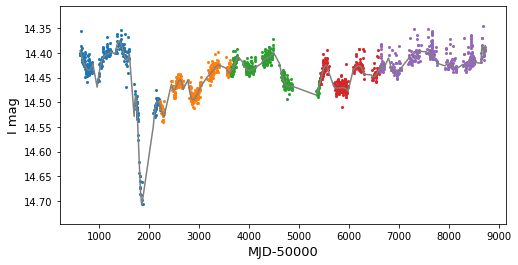

In [52]:
orb = orbchunks(115,0,findpd=True,plotlc=True)

In [42]:
summ[summ['src_n']==141]

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,Type II amp,note,I skew,I kurtosis,V skew,V kurtosis,best auto det pd,Part,I IQR,aperiodic quiescence
107,141,19.91226,-73.50316,0.0,0.72,0.0,0.175075,NaN,15.619686,0.016848,...,NaN,NaN,0.271742,-0.128521,0.279669,-0.494353,5.183714,2.0,0.024,NO


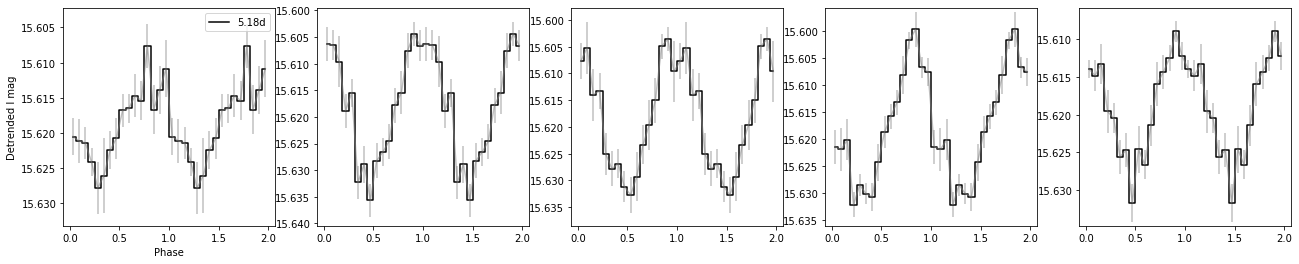

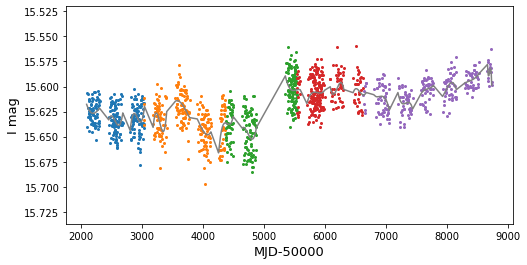

In [53]:
orb = orbchunks(141,0,findpd=True,plotlc=True)

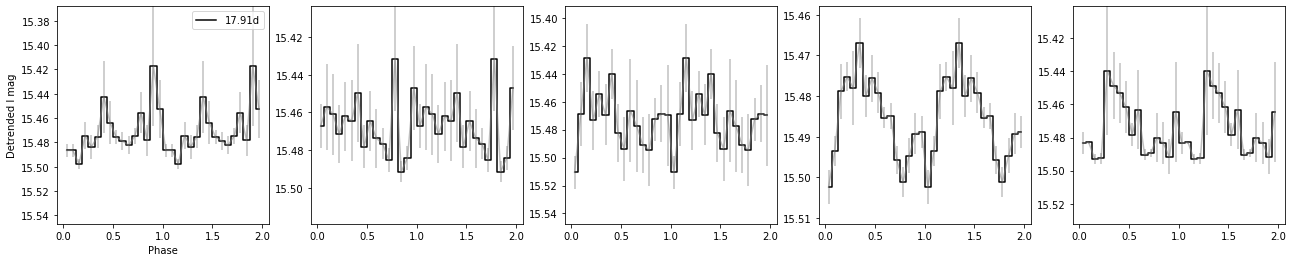

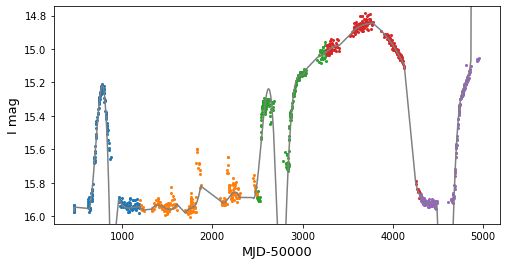

In [44]:
#one that also didn't look as good with the whole LC folded
orb = orbchunks(19,0,findpd=True,plotlc=True)

#### another big dip that looks worse on the ascent 

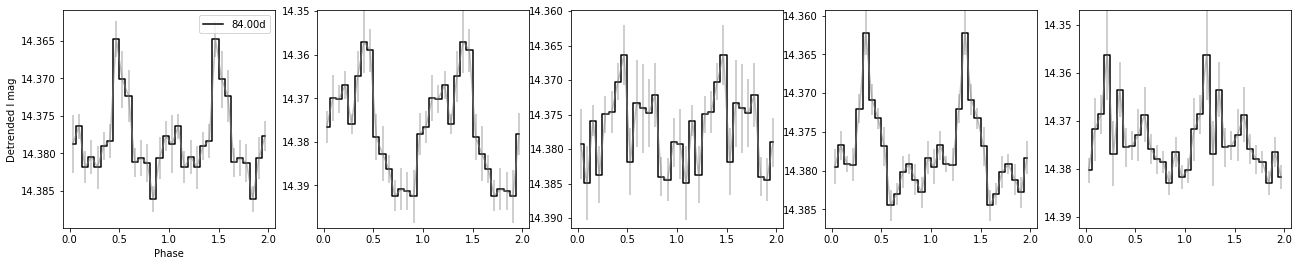

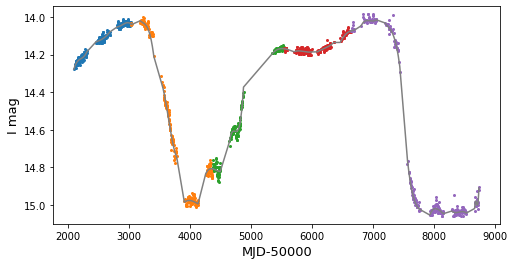

In [45]:
orb = orbchunks(2,0,findpd=True,plotlc=True)

In [47]:
orb

,period,amp,phase diff,phase max,phase min,shape,diff mean,mean,skew,kurtosis,symm sum,mean err,mean I
0,90.441657,0.033603,0.8125,0.90625,0.09375,FRED,0.012585,15.280008,-0.864769,-0.262909,0.009416,0.001875,15.299023
1,90.441657,0.022233,0.8125,0.84375,0.03125,FRED,0.009888,15.284389,-0.442734,-1.032096,0.009696,0.002148,15.306266
2,90.441657,0.047557,0.8750,0.96875,0.09375,FRED,0.012591,15.277377,-1.292470,0.325444,0.015138,0.002321,15.268008
3,90.441657,0.024858,0.1875,0.40625,0.21875,not FRED,0.009499,15.281840,-0.815750,-0.211138,0.008372,0.002465,15.213244
4,90.441657,0.020753,0.5625,0.78125,0.21875,FRED,0.006779,15.282989,-1.079600,0.284476,0.001305,0.002434,15.337054


#### near period, look for value that makes differen chunks cancel out
- i.e. no phase shift
- or phase min in the same bin/lowest deviation

In [22]:
monotonic(np.array([1,2,3,4]))

True

In [25]:
def nearpd(src,bp,day=1,step=0.1,pbins=16,num=5,retlist=False,close=True,samemax=True,stdev=False):
    '''use chunks to find best value in vicinity of best period
    can check if maximum (phase min) occurs in the same phase bin or check for standard deviation within each phase bin (across chunks)
    fairly time-intensive
    
    samemax: identify best period using maximum (loc of min I band)
    stdev: identify best period using mean standard deviation of phase bins for different orbital chunks'''
    #get chunks of LC
    times,mags,det,trend = cut(src,cut=num,glob=True,plot=False,retsplit=True)
    #list for all tables
    alltabs = [] #concatenated after loop
    #loop through periods within day of pd given in steps of step
    periods = np.arange(bp-day,bp+day,step)
    med_std = [] #list of median standard deviations
    for p in periods:
        #get hist info using period
        #pstds: array of standard deviations for each phase bin
        tab,pstds = orbchunks(src,p,findpd=False,plotlc=False,getstd=True)
        #add median standard deviation to list
        med_std.append(np.median(pstds))
        if close: plt.close()
        alltabs.append(tab)
    #two options for identifying best period
    unum = [] #list for number of unique max locations for each period
    maxstd = []
    mono = [] #list of periods that give monotonic change in phase max location
    if samemax: 
        #loop through different period values
        for t in alltabs:
            #get number of unique maxima locations
            num_unique = len(np.unique(t['phase min']))
            unum.append(num_unique)
            #get stdev of maxima locs (quantifying how much it changes)
            maxstd.append(np.std(t['phase min']))
            #look for monotonic change if >= 3 unique maxima locs
            if num_unique >= 3: 
                #if monotonic change, add period to mono list
                if monotonic(np.array(t['phase min'])): mono.append(float(t['period'][0]))

        #sets answer to bestp if there's a unique minimum # of unique max locations
        unum = np.array(unum)
        mins = unum[unum==np.min(unum)]
        minloc = np.where(unum==np.min(unum))
        if len(mins) == 1: #unique minimum
            #location of that one minimum
#             minloc = np.where(unum==np.min(unum))
            bestp = periods[minloc[0][0]]
            print(f'best period: {bestp:.2f}d')

        else: 
            print('no unique number of phase location(s) for max \nnow getting rid of any with monotic change')
            print(f'{len(mins)} with {mins[0]} max locations')
            bestps = periods[minloc]
            #if there are 2, can't check for monotonic trend; but in both cases minimize phase difference between locs
            if mins[0]>=3: 
            #for each period with the min unique num of locs, delete if in list of monotonically increasing or decreasing
            #first print that period b/c could be interesting
                #easier to remove as list
                bestps = list(bestps)
                for b in bestps:
                    if b in mono:
                        print(f'{b} leads to monotonic max loc change, so rejected')
                        bestps.remove(b)
            #get stdevs of phase max locations
            maxstd = np.array(maxstd)
            #stdevs for bestps
            beststd = maxstd[minloc]
            #get lowest stdev, which then determines overall reported best period
            stdloc = np.where(beststd==np.min(beststd))
            bestp = bestps[stdloc[0][0]]
            print(f'best period based on minimizing locations of maxima followed by stdev of maxima loc: {bestp:.2f}d')
        plt.scatter(periods,unum,color='black')
        plt.xlabel('Period');plt.ylabel('Number of Unique Max Locs')   
        
        #phase-fold with final best period
        chunks = len(times)
        fig = plt.figure(figsize=(5*chunks,4))
        for i in range(1,len(times)+1):
            ax = fig.add_subplot(1,chunks,i)
            ax.scatter((times[i-1]%bestp)/bestp,det[i-1],color='palevioletred',alpha=0.4,s=7)
            ax.scatter(1+(times[i-1]%bestp)/bestp,det[i-1],color='palevioletred',alpha=0.4,s=7)
            ax.set_ylim(np.max(det[i-1])+.01,np.min(det[i-1])-.01)
    #instead look for standard deviation between same bin in different orbital chunks
    elif stdev: #minimize median standard deviation in each phase bin across chunks
        #just take period with lowest median standard deviation
        loc = np.where(med_std==np.min(med_std))
        bestp = periods[loc]
        print(f'best period: {bestp} has median stdev across chunks of ') #{med_std[loc]}
        plt.plot(periods,med_std,color='black')
        #phase-fold with best period
        print('add: phase-fold with best period')
    #retlist: return tables in list rather than concatenating
    if retlist: return alltabs
    #combine DataFrames into one table; can differentiate by period column
    tabs = pd.concat(alltabs)
    return tabs

and tests below are using constant phase bins

best period: [17.27] has median stdev across chunks of 
add: phase-fold with best period


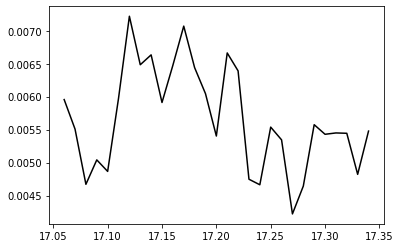

In [26]:
tab = nearpd(6,17.2,day=0.14,step=0.01,samemax=False,stdev=True)

(array([24]),)
best period: 17.30d


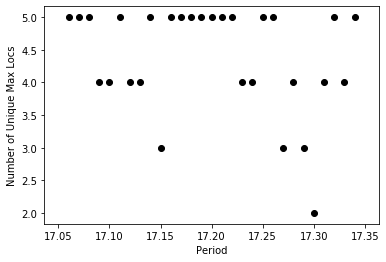

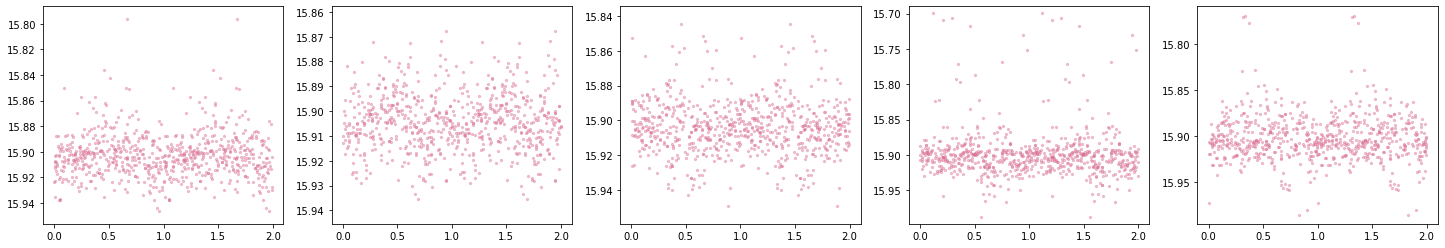

In [110]:
tab = nearpd(6,17.2,day=0.14,step=0.01)

no unique number of phase location(s) for max 
now getting rid of any with monotic change
4 with 3 max locations
17.979999999999986 leads to monotonic max loc change, so rejected
best period based on minimizing locations of maxima followed by stdev of maxima loc: 17.88d


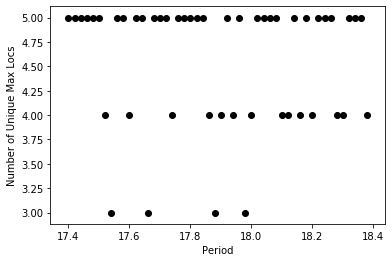

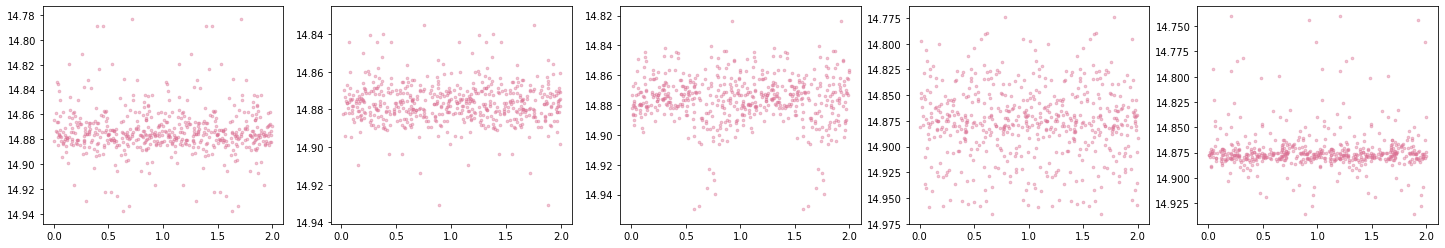

In [112]:
#giving anwer unique to either periodogram or X-ray established
#not taking enough into account in determination
tab = nearpd(3,17.9,day=0.5,step=0.02)

In [46]:
#period search function on whole LC
#take this out of notebook when done, since not using chunks
def maxamp(srcn,bp,day=3,step=0.1,pbins=16,window=200,autodet=True,det=True,plot=True,pdgram=False):
    '''Find best period in small region by maximizing amplitude
    bp: if 0, taken from summ table
    pdgram: overlay final plot with periodogram'''
    #get iband LC
    try: iband = o.getIV(srcn,cross,stack=True,both=False,plot=False,mlist=mlist1)
    except: iband = o.getIV(srcn,cross2,stack=True,both=False,plot=False,mlist=mlist2)
    #spline detrend
    o.splinedetrend(iband,window=window)
    #get best period if 0 passed in 
    if bp==0:
        row = summ[summ['src_n']==srcn]
        if autodet: 
            bp = float(row['best auto det pd'])
        else: bp = float(row['est. period'])
    #array of periods for search
    periods = np.arange(bp-day,bp+day,step)
    #initialize list of amplitudes
    amps = []
    #loop through periods and get amplitude of phase-fold using pbins phase bins
    for p in periods:
        #phase-fold data
        mid,avg,err = o.meanphase(iband,p,pbins=pbins,det=det,double=False,stdev=True,divide=True,sterr=True)
        #get amplitude
        amps.append(np.max(avg)-np.min(avg))
    if plot: 
        plt.plot(periods,amps,color='black')
        plt.ylabel(f'max-min with {pbins} phase bins')
        plt.xlabel('period')
        if pdgram:
            #overlay with periodogram
            freq,power,best = o.periodogram(iband,minp=bp-day,maxp=bp+day,det=True,more=True,plot=False)
            plt.plot(1/freq,power,color='palevioletred',alpha=0.2)
    else: return amps

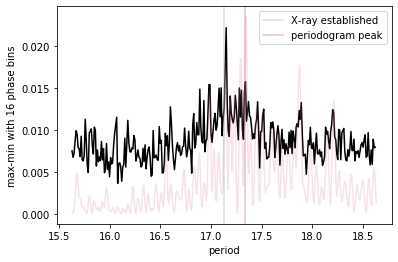

In [28]:
#good example from X-ray
maxamp(6,17.13,day=1.5,step=0.01,pdgram=True)
plt.axvline(17.13,color='darkseagreen',label='X-ray established',alpha=0.4)
plt.axvline(17.34,color=pink,label='periodogram peak',alpha=0.4)
plt.legend()
# plt.savefig('Figs/epochfoldsrc6.png',dpi=200,bbox_inches='tight')

In [32]:
summ[:3]

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,Type II amp,note,I skew,I kurtosis,V skew,V kurtosis,best auto det pd,Part,I IQR,aperiodic quiescence
0,1,19.271511,-73.443405,0.717,0.5,3.892,0.404107,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,NaN,NO
1,2,20.418930,-72.959070,2.165,2.0,84.000,2.147143,NaN,14.379506,0.356251,...,NaN,revisit alias and 6.8,0.768988,-1.033376,-1.537777,1.704585,83.985070,1.0,0.5845,NO
2,3,13.639167,-73.683640,2.370,0.8,18.380,0.259701,NaN,14.877813,0.267369,...,NaN,~1 day error on pd,1.698965,2.086592,1.458121,0.808846,17.404354,1.0,0.2325,NO


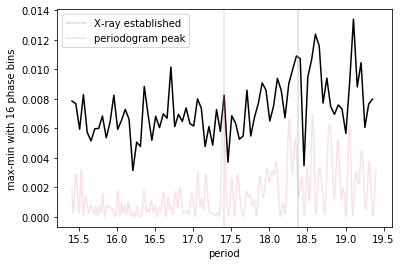

In [47]:
#it doesn't automatically work well, but see that the amp is better at 18.38 than 17.4
#should really add twinx since label is wrong for periodogram
maxamp(3,0,day=2,step=0.05,pdgram=True)
plt.axvline(18.38,color='darkseagreen',label='X-ray established',alpha=0.4)
plt.axvline(17.4,color=pink,label='periodogram peak',alpha=0.2)
plt.legend()
plt.savefig('Figs/src3_ampfold.png',dpi=150,bbox_inches='tight')

In [39]:
summ[summ['src_n']==12]

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,Type II amp,note,I skew,I kurtosis,V skew,V kurtosis,best auto det pd,Part,I IQR,aperiodic quiescence
11,12,12.327084,-73.20028,9.13,40.0,77.2,0.0,NaN,16.229427,0.084721,...,NaN,disagreement with est.,-0.287022,-0.348482,-1.02316,0.850715,80.847781,1.0,0.128,NO


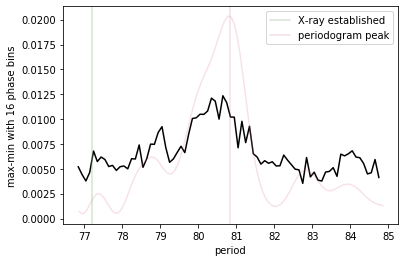

In [41]:
#case where methods look similar
maxamp(12,0,day=4,step=0.1,pdgram=True)
plt.axvline(77.2,color='darkseagreen',label='X-ray established',alpha=0.4)
plt.axvline(80.84,color=pink,label='periodogram peak',alpha=0.2)
plt.legend()
#31 similar

In [46]:
summ[summ['src_n']==44]

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,Type II amp,note,I skew,I kurtosis,V skew,V kurtosis,best auto det pd,Part,I IQR,aperiodic quiescence
39,44,14.455669,-72.0432,280.4,0.5,64.8,1.173049,NaN,15.388894,0.06577,...,NaN,NaN,-0.167377,-1.08648,-0.344749,-0.217247,63.569633,1.0,0.113,NO


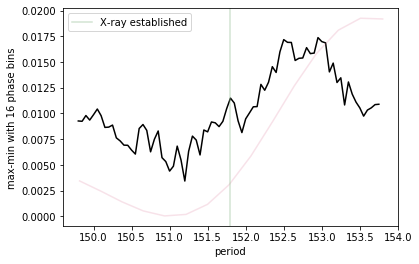

In [50]:
maxamp(56,151.8,day=2,step=0.05,pdgram=True)
plt.axvline(151.8,color='darkseagreen',label='X-ray established',alpha=0.4)
# plt.axvline(80.84,color=pink,label='periodogram peak',alpha=0.2)
plt.legend()

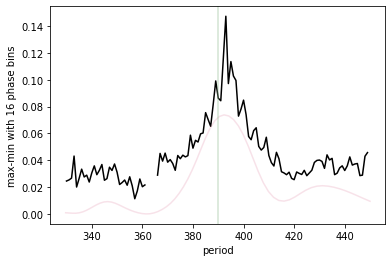

In [52]:
#weird result based on notes on this source
maxamp(60,390,day=60,step=1,pdgram=True)
plt.axvline(390,color='darkseagreen',label='X-ray established',alpha=0.4)

In [65]:
nearpd(22,90.44,1,step=0.1)

,period,amp,phase diff,phase max,phase min,shape,diff mean,mean,skew,kurtosis,symm sum,mean err,mean I
0,89.44,0.031484,0.7500,0.15625,0.40625,not FRED,0.011446,15.279654,-0.891475,0.454472,0.006749,0.002243,15.299023
1,89.44,0.025654,0.6875,0.34375,0.65625,not FRED,0.014684,15.284462,0.085627,-0.203517,0.002935,0.002245,15.306266
2,89.44,0.044383,0.6875,0.46875,0.78125,not FRED,0.012302,15.277777,-1.234116,0.737245,0.009785,0.002692,15.268008
3,89.44,0.030684,0.1875,0.15625,0.96875,FRED,0.013586,15.281483,-0.583989,-0.101770,0.008581,0.002370,15.213244
4,89.44,0.016986,0.5625,0.71875,0.15625,FRED,0.006797,15.282807,-0.753303,-0.663682,0.002243,0.002561,15.337054
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,91.34,0.033962,0.8125,0.59375,0.78125,not FRED,0.012012,15.279780,-0.987200,0.201535,0.010171,0.002021,15.299023
1,91.34,0.023254,0.8125,0.46875,0.65625,not FRED,0.011750,15.284014,-0.086663,-0.798546,0.008662,0.002249,15.306266
2,91.34,0.038492,0.7500,0.34375,0.59375,not FRED,0.013966,15.277059,-0.780196,-0.791215,0.009529,0.002474,15.268008
3,91.34,0.019847,0.1875,0.78125,0.59375,not FRED,0.006849,15.282026,-0.738083,-0.584263,0.008582,0.002592,15.213244


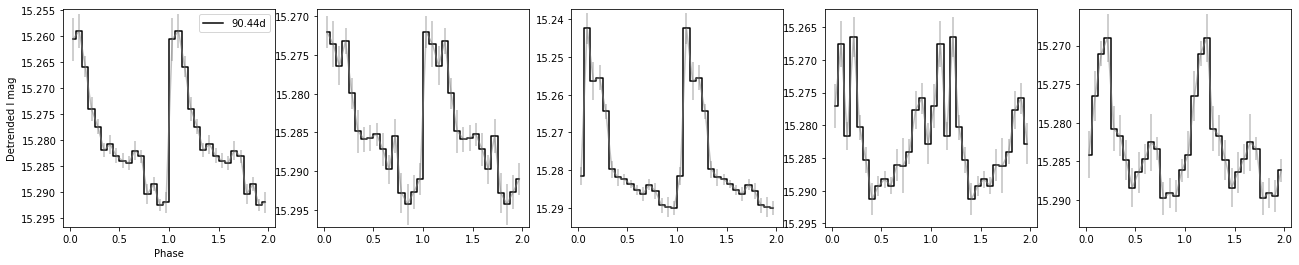

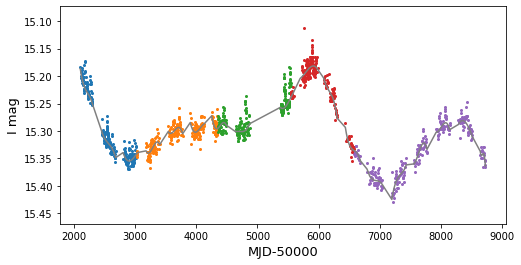

In [46]:
orb = orbchunks(22,0,findpd=True,plotlc=True)

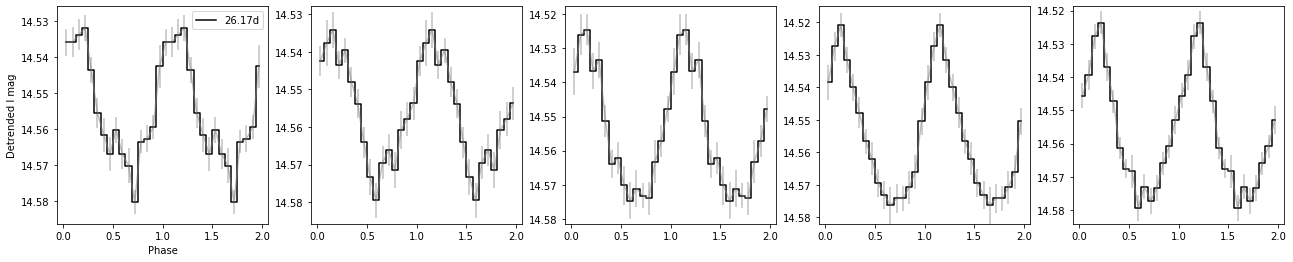

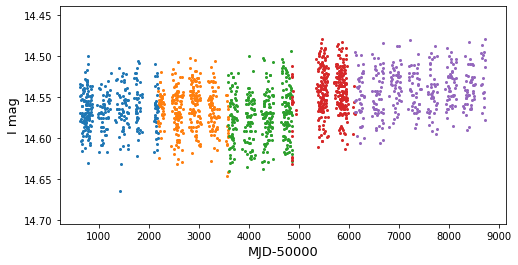

In [194]:
orb = orbchunks(64,0,findpd=True,plotlc=True) #relatively quite stable (whether 26.17 or 26.19 but perhaps can differentiate by phase)

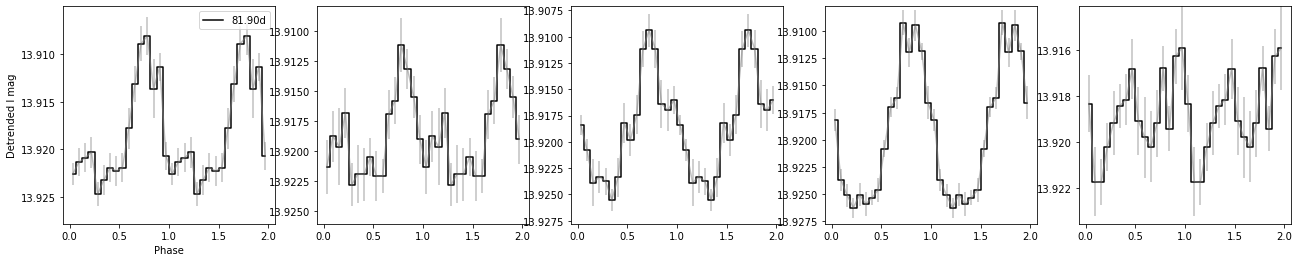

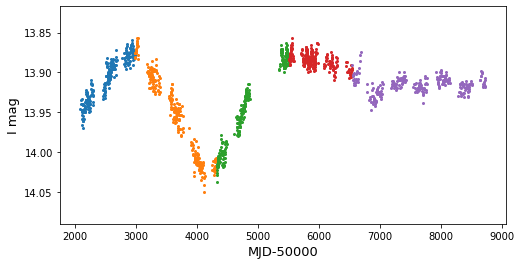

In [197]:
orb = orbchunks(4,0,findpd=True,plotlc=True) #ascent looks good so that property isn't universal with big dips

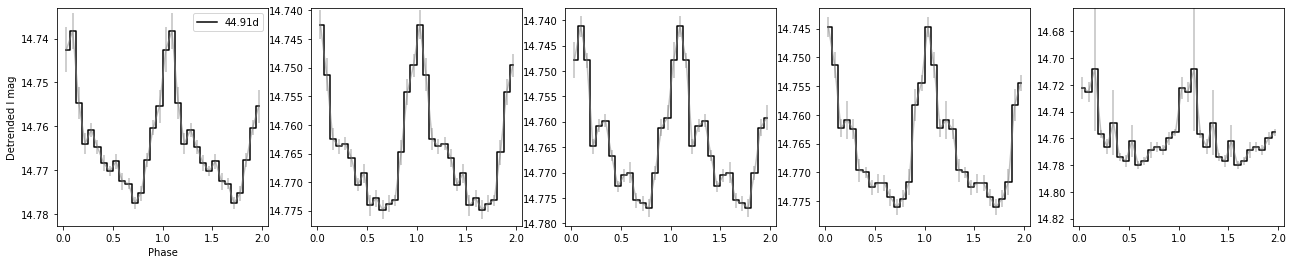

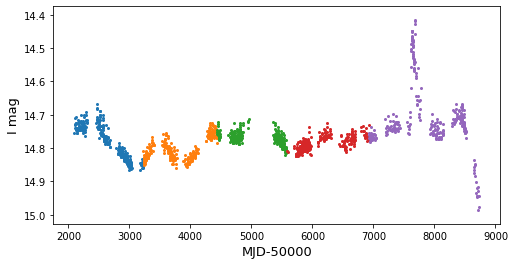

In [198]:
orb = orbchunks(9,0,findpd=True,plotlc=True) #very consistent; end could be b/c of difficult detrending (see errors)

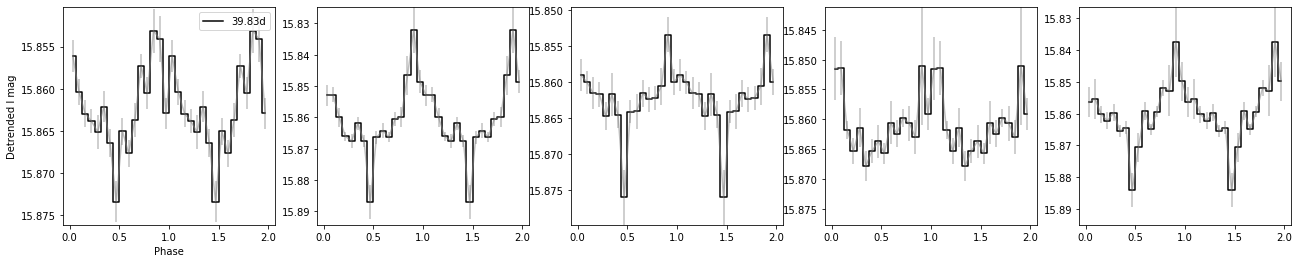

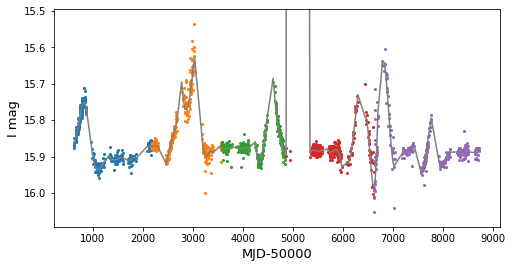

In [49]:
orb = orbchunks(10,0,findpd=True,plotlc=True,save=True,file='Figs/src10chunkfolds') #interesting shape w/ dips; corroborated by how it shows up in separate chunks
# plt.savefig('Figs/src10chunks.png',dpi=150,bbox_inches='tight')

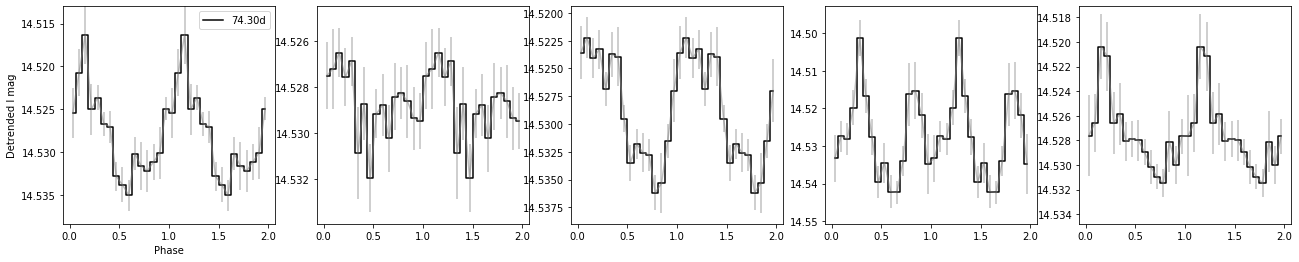

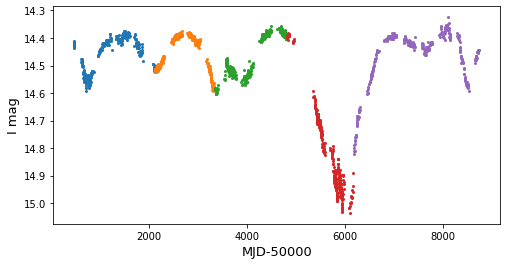

In [200]:
orb = orbchunks(16,0,findpd=True,plotlc=True)

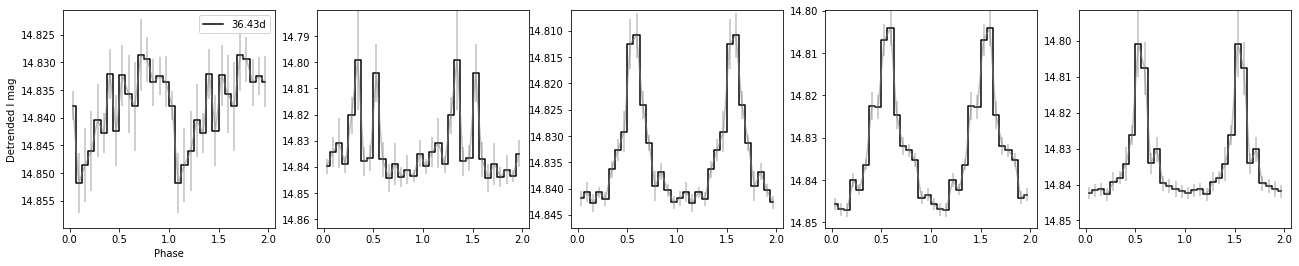

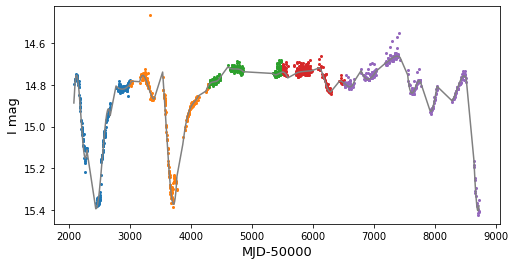

In [50]:
orb = orbchunks(17,0,findpd=True,plotlc=True) #check if detrending issue or physical

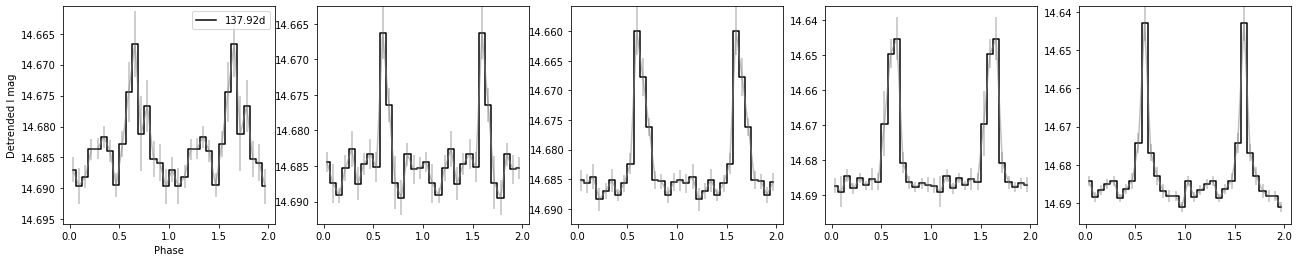

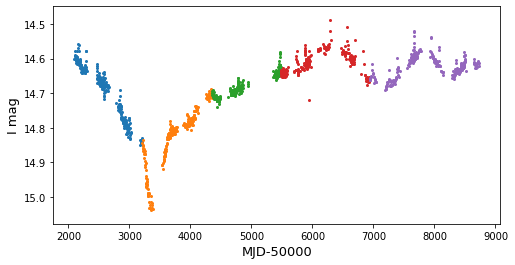

In [202]:
orb = orbchunks(23,0,findpd=True,plotlc=True)

empty file for OIII I


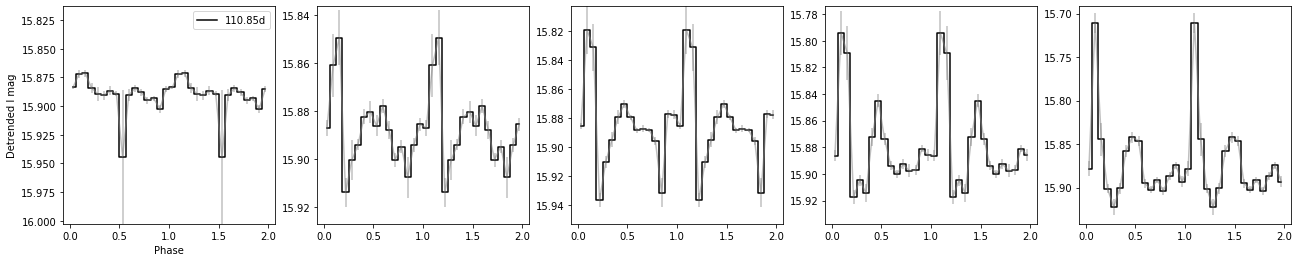

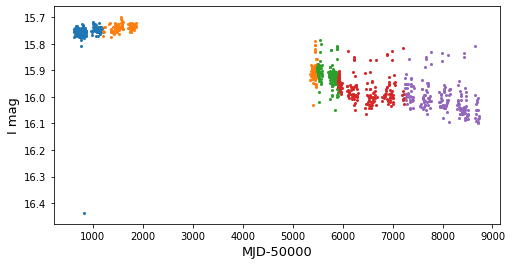

In [204]:
orb = orbchunks(25,0,findpd=True,plotlc=True) #meaning of double-peaked shape?

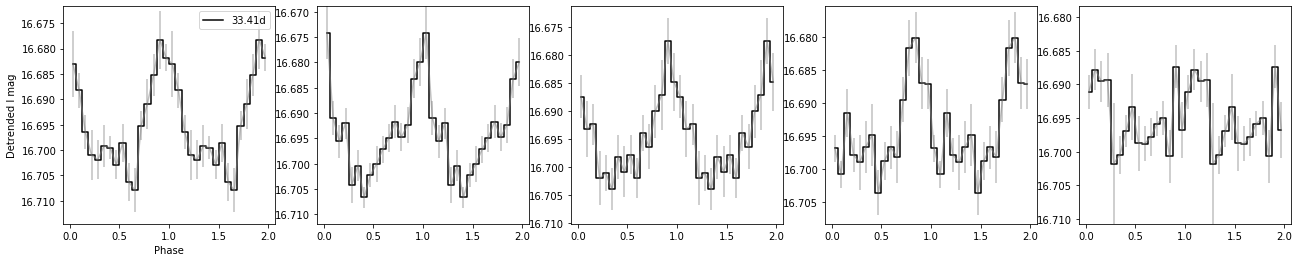

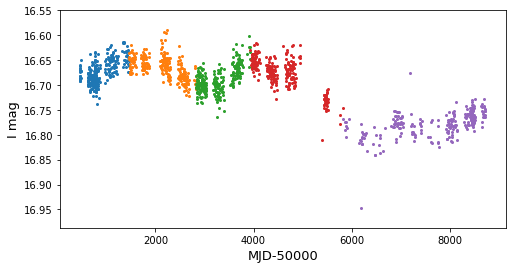

In [205]:
orb = orbchunks(26,0,findpd=True,plotlc=True)

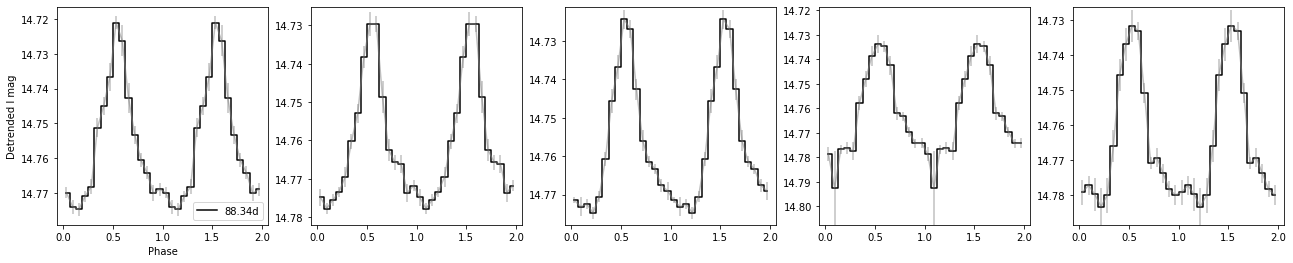

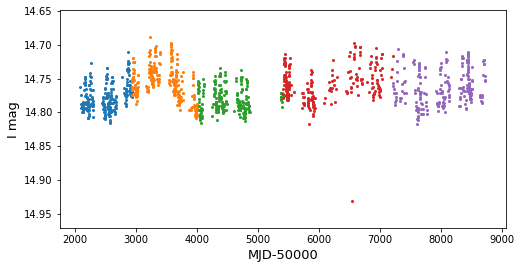

In [206]:
orb = orbchunks(28,0,findpd=True,plotlc=True)

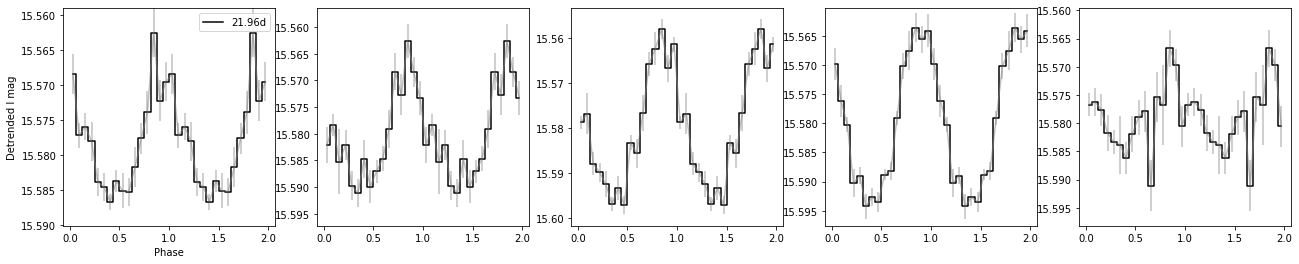

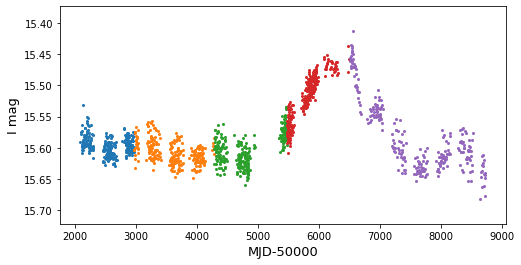

In [207]:
orb = orbchunks(30,0,findpd=True,plotlc=True)

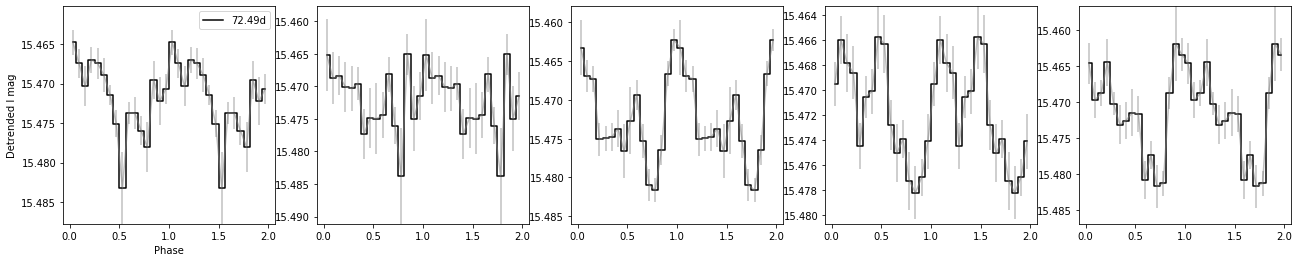

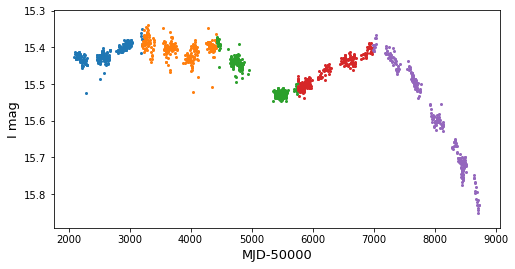

In [208]:
orb = orbchunks(34,0,findpd=True,plotlc=True)

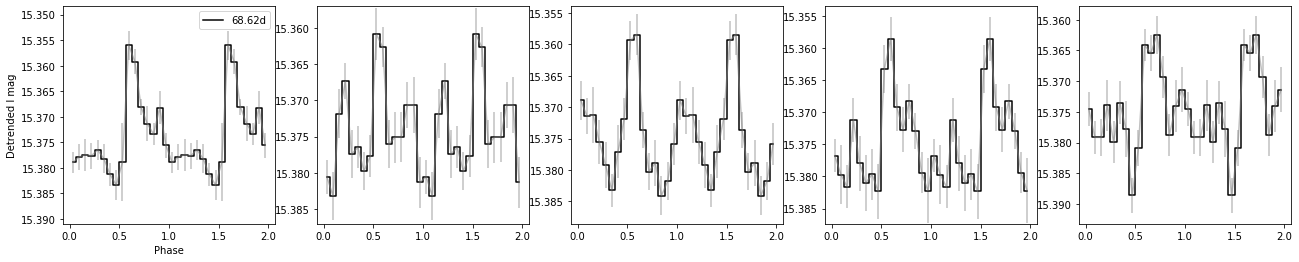

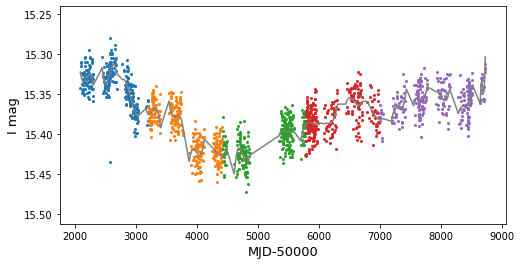

In [51]:
orb = orbchunks(36,0,findpd=True,plotlc=True) #should follow up

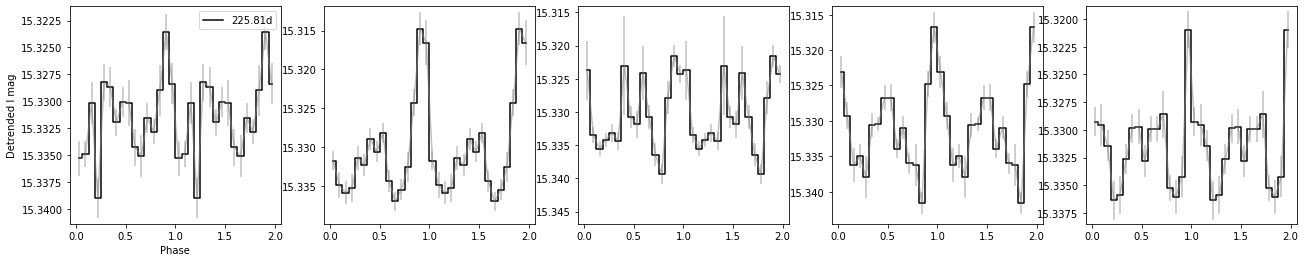

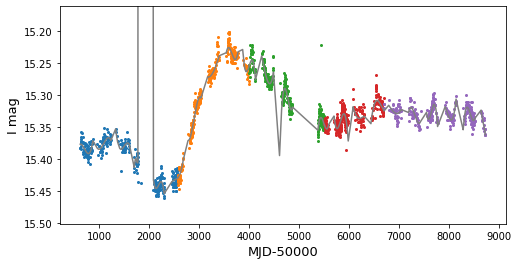

In [52]:
orb = orbchunks(40,0,findpd=True,plotlc=True)

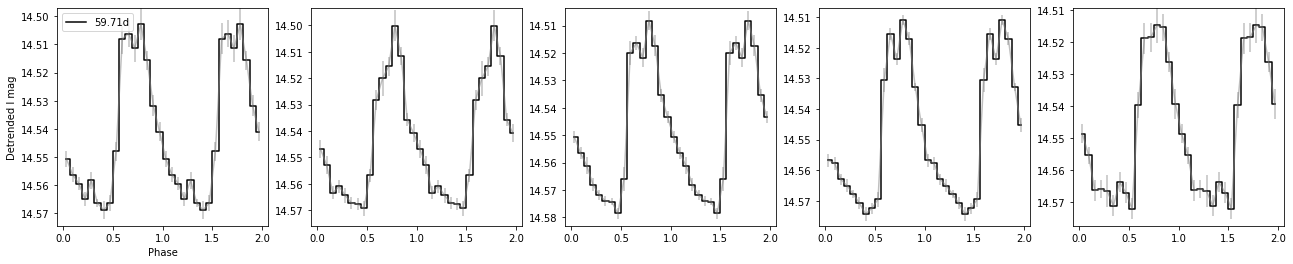

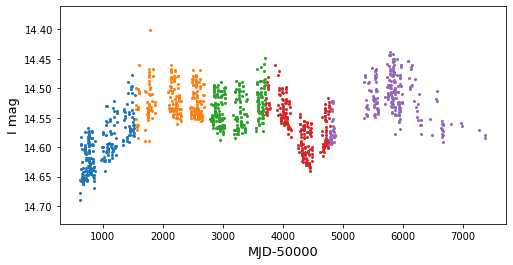

In [213]:
orb = orbchunks(45,0,findpd=True,plotlc=True) #consistent

In [215]:
# orb = orbchunks(48,0,findpd=True,plotlc=True) #figure out error here

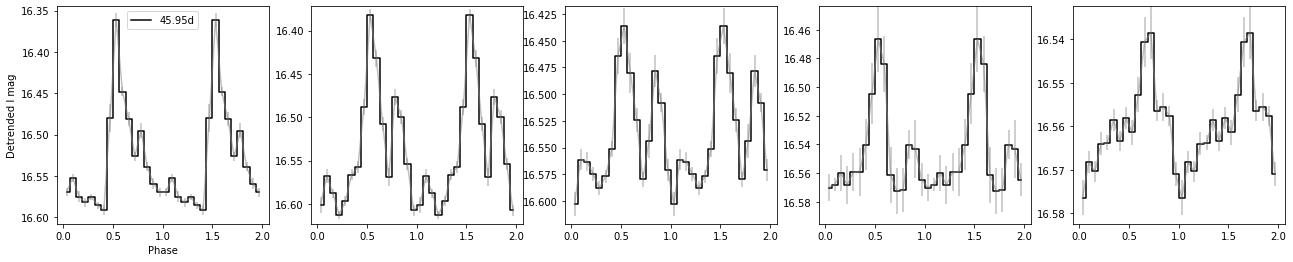

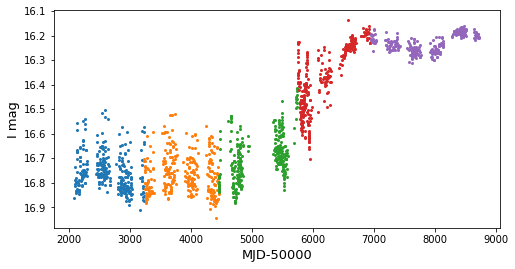

In [216]:
orb = orbchunks(50,0,findpd=True,plotlc=True) #follow this up

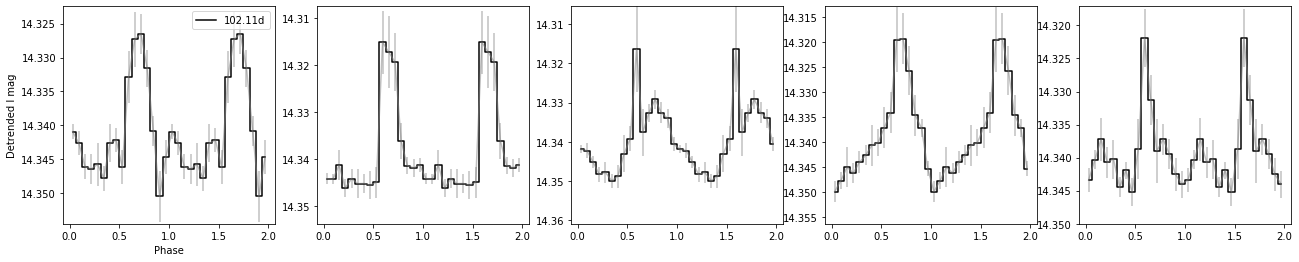

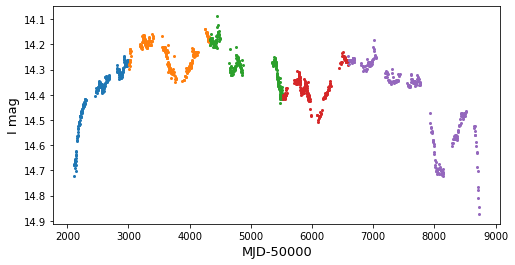

In [217]:
orb = orbchunks(62,0,findpd=True,plotlc=True)

In [219]:
# orb = orbchunks(63,0,findpd=True,plotlc=True)